In [1]:
#!pip install torchvision

# ДЗ №2 по курсу "Математические основы машинного обучения - Компьютерное зрение", УрФУ.

## Описание датасета

Датасет CIFAR-10 состоит из 60000 цветных картинок размером 32х32 с 6000 шт. картинок на каждый класс: 50000 тренировочных и 10000 тестовых картинок.


The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each clas

Набор данных разделен на пять обучающих батчей и один тестовый батч, каждый из которых содержит 10000 изображений. Тестовый батч содержит ровно 1000 случайно выбранных изображений из каждого класса. Обучающие батчи содержат оставшиеся изображения в случайном порядке, но некоторые обучающие пакеты могут содержать больше изображений из одного класса, чем из другого. В совокупности обучающие пакеты содержат ровно 5000 изображений из каждого класса.s.Датасет содержит следующие классы:
a


1. airplane
2. automobile
3. bird
4. cat
5. deer
6. dog
7. frog
8. hor
9. ship
10. truck

Классы полностью взаимоисключающие, даже нет пересечений между "Автомобилями" и "Грузовиками" (никто не включает пикапы).).s pickup trucks.

In [2]:
# Импортируем библиотеки
import torch
import torchvision.datasets
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor

import shutil
import torch.optim as optim
from tqdm.notebook import tqdm
from torch.utils.tensorboard import SummaryWriter

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

random.seed(0)
np.random.seed(0)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True

In [3]:
# Проверяем подключение GPU
!nvidia-smi
!nvcc --version

Thu Oct  3 19:13:30 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
transform = transforms.Compose(
        [
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261])
        ]
    )

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
BATCH_SIZE = 64
EPOCHS = 100

In [6]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

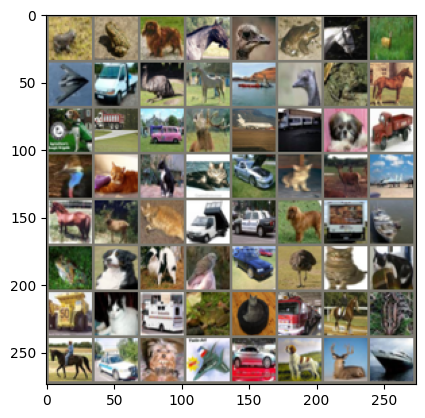

frog  frog  dog   horse


In [17]:
def imshow(img):
    std = torch.tensor([0.247, 0.243, 0.261])[:,None,None]
    mean = torch.tensor([0.4914, 0.4822, 0.4465])[:,None,None]
    img = img*std + mean   # unnormalize
    npimg = np.clip(img.numpy(), 0, 1)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
images, labels = next(iter(trainloader))

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [8]:
def train_loop(dataloader, model, loss_fn, optimizer, epoch_n, device, summary_writer):
    len_of_dataset = len(dataloader.dataset)
    batch_size = dataloader.batch_size
    num_batches = len(dataloader)

    train_loss, train_accuracy = 0, 0
    model.train()
    with tqdm(dataloader, unit='batch') as tepoch:
        for images, labels in tepoch:

            # Определяем описание для tqdm
            tepoch.set_description(f'Epoch {epoch_n}')

            images, labels = images.to(device), labels.to(device)
            # Делаем forward pass
            pred = model(images)
            # вычисляем loss
            loss = loss_fn(pred, labels)

            # Вычисляем градиенты
            optimizer.zero_grad()
            loss.backward()

            # Делаем шаг оптимизатора
            optimizer.step()

            # Вычисляем количество правильных ответов
            correct = (pred.argmax(1) == labels).sum().item()
            accuracy = correct / images.shape[0]

            # Прибавляем loss и accuracy к полным значениям за эпоху
            train_loss += loss.item()
            train_accuracy += correct
            # Выводим в tqdm текущие лосс и точность
            tepoch.set_postfix(loss=loss.item(), accuracy=accuracy)

    # вычисляем среднее
    train_loss /= num_batches
    train_accuracy /= len_of_dataset

    # Записываем в тензорборд
    summary_writer.add_scalar(
        'train/loss',
        train_loss,
        epoch_n
    )

    summary_writer.add_scalar(
        'train/accuracy',
        train_accuracy,
        epoch_n
    )

In [9]:
def test_loop(dataloader, model, loss_fn, epoch_n,  device, summary_writer):
    len_of_dataset = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    model.eval()
    # На этапе валидации нам не нужно вычислять градиенты
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            pred = model(images)
            test_loss += loss_fn(pred, labels).item()
            correct += (pred.argmax(1) == labels).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= len_of_dataset

    summary_writer.add_scalar(
        'test/loss',
        test_loss,
        epoch_n
    )

    summary_writer.add_scalar(
        'test/accuracy',
        correct,
        epoch_n
    )

    if epoch_n % 10 == 0:
        print(f'Test Metrics: \n Accuracy: {(correct):>0.3f}, Avg loss: {test_loss:>8f} \n')

In [13]:
class MyNet(torch.nn.Module):
    def __init__(self, in_channels: int = 3, num_of_classes: int = 10):
        super(MyNet, self).__init__()

        self.conv_block = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, 10, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(10),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(10, 20, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(20),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Conv2d(20, 40, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(40),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.linear_block = torch.nn.Sequential(
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(40*8*8, 1024),
            torch.nn.BatchNorm1d(1024),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(1024, 256),
            torch.nn.BatchNorm1d(256),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(256, num_of_classes),
            torch.nn.Softmax(dim=1),
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)
        x = self.linear_block(x)
        return x



In [14]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = MyNet()
net.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1.0e-4)

shutil.rmtree('runs/mynet', ignore_errors=True)
writer = SummaryWriter('runs/mynet')
for epoch_n in range(EPOCHS):
    train_loop(trainloader, net, criterion, optimizer, epoch_n, device, writer)
    test_loop(testloader, net, criterion, epoch_n, device, writer)
print("Done!")

  0%|          | 0/782 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.482, Avg loss: 1.993130 



  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.689, Avg loss: 1.777968 



  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.726, Avg loss: 1.738585 



  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.748, Avg loss: 1.715503 



  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.766, Avg loss: 1.698030 



  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.773, Avg loss: 1.689167 



  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.777, Avg loss: 1.683940 



  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.789, Avg loss: 1.673111 



  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.790, Avg loss: 1.671261 



  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.796, Avg loss: 1.666423 



  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

  0%|          | 0/782 [00:00<?, ?batch/s]

Done!


In [23]:
torch.save(net, "model.pth")

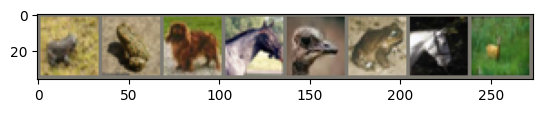

frog  frog  dog   horse bird  frog  horse deer 


In [24]:
# show images
imshow(torchvision.utils.make_grid(images[:8]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))

In [25]:
images, labels = images.to(device), labels.to(device)
pred = net(images)

In [28]:
[classes[item] for item in pred.argmax(1)[:8]]

['frog', 'frog', 'dog', 'horse', 'bird', 'frog', 'horse', 'deer']

In [29]:
test_loop(testloader, net, criterion, 100, device, writer)

Test Metrics: 
 Accuracy: 0.796, Avg loss: 1.666337 

